<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 3 Assignment 2*
# Convolutional Neural Networks (CNNs)

# Assignment

- <a href="#p1">Part 1:</a> Pre-Trained Model
- <a href="#p2">Part 2:</a> Custom CNN Model
- <a href="#p3">Part 3:</a> CNN with Data Augmentation


You will apply three different CNN models to a binary image classification model using Keras. Classify images of Mountains (`./data/mountain/*`) and images of forests (`./data/forest/*`). Treat mountains as the postive class (1) and the forest images as the negative (zero). 

|Mountain (+)|Forest (-)|
|---|---|
|![](./data/mountain/art1131.jpg)|![](./data/forest/cdmc317.jpg)|

The problem is realively difficult given that the sample is tiny: there are about 350 observations per class. This sample size might be something that you can expect with prototyping an image classification problem/solution at work. Get accustomed to evaluating several differnet possible models.

# Pre - Trained Model
<a id="p1"></a>

Load a pretrained network from Keras, [ResNet50](https://tfhub.dev/google/imagenet/resnet_v1_50/classification/1) - a 50 layer deep network trained to recognize [1000 objects](https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt). Starting usage:

```python
import numpy as np

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D()
from tensorflow.keras.models import Model # This is the functional API

resnet = ResNet50(weights='imagenet', include_top=False)

```

The `include_top` parameter in `ResNet50` will remove the full connected layers from the ResNet model. The next step is to turn off the training of the ResNet layers. We want to use the learned parameters without updating them in future training passes. 

```python
for layer in resnet.layers:
    layer.trainable = False
```

Using the Keras functional API, we will need to additional additional full connected layers to our model. We we removed the top layers, we removed all preivous fully connected layers. In other words, we kept only the feature processing portions of our network. You can expert with additional layers beyond what's listed here. The `GlobalAveragePooling2D` layer functions as a really fancy flatten function by taking the average of each of the last convolutional layer outputs (which is two dimensional still). 

```python
x = res.output
x = GlobalAveragePooling2D()(x) # This layer is a really fancy flatten
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(res.input, predictions)
```

Your assignment is to apply the transfer learning above to classify images of Mountains (`./data/mountain/*`) and images of forests (`./data/forest/*`). Treat mountains as the postive class (1) and the forest images as the negative (zero). 

Steps to complete assignment: 
1. Load in Image Data into numpy arrays (`X`) 
2. Create a `y` for the labels
3. Train your model with pretrained layers from resnet
4. Report your model's accuracy

## Load in Data

![skimage-logo](https://scikit-image.org/_static/img/logo.png)

Check out out [`skimage`](https://scikit-image.org/) for useful functions related to processing the images. In particular checkout the documentation for `skimage.io.imread_collection` and `skimage.transform.resize`.

In [1]:
# Downgrade numpy to work with skimage (apparently)
import numpy as np
print(np.__version__)

1.14.5


In [2]:
from skimage import io
from skimage import transform
import pandas as pd

import numpy as np

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model # This is the functional API

In [3]:
# Load in image collections
forests = io.imread_collection('data/forest/*.jpg')
mountains = io.imread_collection('data/mountain/*.jpg')

In [4]:
# Check out how many forests and mountains we have
len(forests), len(mountains)

(328, 374)

In [5]:
# Label data
mountains_labeled = []
for m in mountains:
   mountains_labeled.append([m, 1])

forests_labeled = []
for f in forests:
   forests_labeled.append([f, 0])

In [6]:
# Check that labeled lists have correct outputs
assert mountains_labeled[100][1] == 1
assert forests_labeled[200][1] == 0

In [7]:
# Lump into one array 
data = np.concatenate((mountains_labeled, forests_labeled), axis=0)

In [8]:
type(data)

numpy.ndarray

In [9]:
assert len(mountains_labeled) + len(forests_labeled) == len(data)

In [10]:
data.shape

(702, 2)

In [11]:
# Split data into X and y
X = data[:,0]
y = (data[:,1]).astype(int)

X.shape, y.shape

((702,), (702,))

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((526,), (176,), (526,), (176,))

In [13]:
#Preprocess X_train & X_test
X_train = np.array([preprocess_input(x) for x in X_train])
X_test = np.array([preprocess_input(x) for x in X_test])

In [14]:
X_train.shape, X_test.shape

((526, 256, 256, 3), (176, 256, 256, 3))

## Instatiate Model

In [22]:
#Pretrained model
baseModel = ResNet50(weights='imagenet', include_top=False)

for layer in baseModel.layers:
    layer.trainable = False
    
x = baseModel.output
x = GlobalAveragePooling2D()(x) # This layer is a really fancy flatten
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(baseModel.input, predictions)

model.compile(optimizer='adam',
 loss='binary_crossentropy', metrics=['accuracy'])

## Fit Model

In [23]:
model.fit(X_train, y_train, epochs=3,
              validation_data=(X_test, y_test))

Train on 526 samples, validate on 176 samples
Epoch 1/3
526/526 [==============================] - 129s 246ms/sample - loss: 0.7788 - acc: 0.7909 - val_loss: 0.3664 - val_acc: 0.8636
Epoch 2/3
526/526 [==============================] - 119s 226ms/sample - loss: 0.1384 - acc: 0.9525 - val_loss: 0.3461 - val_acc: 0.8750
Epoch 3/3
526/526 [==============================] - 133s 252ms/sample - loss: 0.0435 - acc: 0.9810 - val_loss: 0.2038 - val_acc: 0.9318


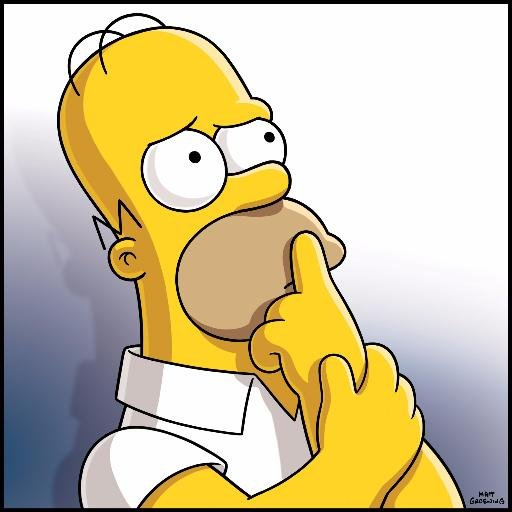

In [26]:
from IPython.display import Image
Image(filename='./homer.jpg', width=300)

# Custom CNN Model

In this step, write and train your own convolutional neural network using Keras. You can use any architecture that suits you as long as it has at least one convolutional and one pooling layer at the beginning of the network - you can add more if you want. 

In [95]:
# under construction

model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 215, 215, 32)      9632      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 39, 39, 64)        51264     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 9, 9, 64)          102464    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5184)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)               

In [96]:
# Compile Model


In [99]:
# Fit Model


Train on 561 samples, validate on 141 samples
Epoch 1/5
561/561 [==============================] - 18s 32ms/sample - loss: 0.2667 - accuracy: 0.9073 - val_loss: 0.1186 - val_accuracy: 0.9858
Epoch 2/5
561/561 [==============================] - 18s 32ms/sample - loss: 0.2046 - accuracy: 0.9073 - val_loss: 0.3342 - val_accuracy: 0.8511
Epoch 3/5
561/561 [==============================] - 18s 32ms/sample - loss: 0.1778 - accuracy: 0.9287 - val_loss: 0.2746 - val_accuracy: 0.8723
Epoch 4/5
561/561 [==============================] - 18s 32ms/sample - loss: 0.1681 - accuracy: 0.9323 - val_loss: 0.8487 - val_accuracy: 0.5957
Epoch 5/5
561/561 [==============================] - 18s 32ms/sample - loss: 0.1606 - accuracy: 0.9394 - val_loss: 0.3903 - val_accuracy: 0.8582


# Custom CNN Model with Image Manipulations
## *This a stretch goal, and it's relatively difficult*

To simulate an increase in a sample of image, you can apply image manipulation techniques: cropping, rotation, stretching, etc. Luckily Keras has some handy functions for us to apply these techniques to our mountain and forest example. Check out these resources to help you get started: 

1. [Keras `ImageGenerator` Class](https://keras.io/preprocessing/image/#imagedatagenerator-class)
2. [Building a powerful image classifier with very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
 

In [ ]:
# State Code for Image Manipulation Here

# Resources and Stretch Goals

Stretch goals
- Enhance your code to use classes/functions and accept terms to search and classes to look for in recognizing the downloaded images (e.g. download images of parties, recognize all that contain balloons)
- Check out [other available pretrained networks](https://tfhub.dev), try some and compare
- Image recognition/classification is somewhat solved, but *relationships* between entities and describing an image is not - check out some of the extended resources (e.g. [Visual Genome](https://visualgenome.org/)) on the topic
- Transfer learning - using images you source yourself, [retrain a classifier](https://www.tensorflow.org/hub/tutorials/image_retraining) with a new category
- (Not CNN related) Use [piexif](https://pypi.org/project/piexif/) to check out the metadata of images passed in to your system - see if they're from a national park! (Note - many images lack GPS metadata, so this won't work in most cases, but still cool)

Resources
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) - influential paper (introduced ResNet)
- [YOLO: Real-Time Object Detection](https://pjreddie.com/darknet/yolo/) - an influential convolution based object detection system, focused on inference speed (for applications to e.g. self driving vehicles)
- [R-CNN, Fast R-CNN, Faster R-CNN, YOLO](https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e) - comparison of object detection systems
- [Common Objects in Context](http://cocodataset.org/) - a large-scale object detection, segmentation, and captioning dataset
- [Visual Genome](https://visualgenome.org/) - a dataset, a knowledge base, an ongoing effort to connect structured image concepts to language